In [ ]:
# https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#fourier-order-for-seasonalities

In [ ]:
# adding regressors to Prophet model

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov  6 14:44:31 2018
Modified on Fri, Dec 14 2018
Modified on Mon, Jan 7 2018
@author: ahellman; akuppam; trenner
"""
import numpy as np
import pandas as pd
import itertools
#import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from fbprophet import Prophet
#from fbprophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import logging
import warnings
import pyper as pr


log_fmt = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
logging.basicConfig(level=logging.INFO, format=log_fmt)
logger = logging.getLogger(__name__)


class TimeSeriesMultiReg():
    
    def __init__(self):
        pass
    
    
    def _Run_Regressions(
        self,
        df,
        forecastDays,
        region="None",
        forecasts={"holtwinters", "arima", "sarima", "prophet", "r_arima", "r_sarima"}
    ):
        """This is the main working function to:
            1. break out the arrays from the dataset
            2. Call the other functions
            3. Run the MAPE on each of the functions"""
        
        df = self.format_df(df)
        

        actualsDict = self.dimensionDictionary(df)
        
        actualsDictKey = []
        for key in actualsDict:
            actualsDictKey.append(key)  
        
        # Fill dictionary with unique intersections of the actuals data:
        for i in range(0, len(actualsDictKey)):
            dfFiltered = df.iloc[0:,1].isin(actualsDictKey[i])
            for j in range(1, len(df.columns)-1):
                dfFiltered &= df.iloc[0:,j].isin(actualsDictKey[i])
            
            actualsDict[actualsDictKey[i]] = df[dfFiltered]
        # Fill dictionary with unique uintersections of the actuals data:

        # Dict mapping subdimensions to (model, forecast) tuples.
        # model, forecast = forecast_results[subdimension] <- how to call.
        forecast_results = {}
        
        # If 0 Dims, do this:
        if len(actualsDictKey) == 0:
            actualsDictKey.append('y')
            actualsDict['y'] = df[['y']]
        
        for subDimension in actualsDictKey:
            # Initialize the list of forecast results for the subdimension.
            forecast_results[subDimension] = []
            if "prophet" in forecasts:
                try:
                    if region == "None":
                        forecast_results[subDimension].append((
                            "Prophet",
                            self.ProphetFxnNone(
                                actualsDict[subDimension],
                                forecastDays
                            )
                        ))
                    elif region == "NA":
                        forecast_results[subDimension].append((
                            "Prophet",
                            self.ProphetFxnNA(
                                actualsDict[subDimension],
                                forecastDays
                            )
                        ))
                    elif region == "UK":
                        forecast_results[subDimension].append((
                            "Prophet",
                            self.ProphetFxnUK(
                                actualsDict[subDimension],
                                forecastDays
                            )
                        ))
                    elif region == "FR":
                        forecast_results[subDimension].append((
                            "Prophet",
                            self.ProphetFxnFR(
                                actualsDict[subDimension],
                                forecastDays
                            )
                        ))
                    elif region == "CE":
                        forecast_results[subDimension].append((
                            "Prophet",
                            self.ProphetFxnCE(
                                actualsDict[subDimension],
                                forecastDays
                            )
                        ))
                    elif region == "SoEu":
                        forecast_results[subDimension].append((
                            "Prophet",
                            self.ProphetFxnSoEu(
                                actualsDict[subDimension],
                                forecastDays
                            )
                        ))
                except Exception:
                    pass  # If we can't run this without generating exceptions, skip.
            
            if "holtwinters" in forecasts:
                try:
                    forecast_results[subDimension].append(
                        (
                            "HW",
                            self.HWFxn(
                                actualsDict[subDimension],
                                forecastDays
                            )
                        )
                    )
                except Exception:
                    pass  # If we can't run this without generating exceptions, skip.
            
            if "sarima" in forecasts:
                try:
                    forecast_results[subDimension].append(
                        (
                            "Sarima",
                            self.SarimaFxn(
                                actualsDict[subDimension],
                                forecastDays
                            )
                        )
                    )
                except Exception:
                    pass  # If we can't run this without generating exceptions, skip.
            
            if "r_sarima" in forecasts:
                try:
                    forecast_results[subDimension].append(
                        (
                            "r_Sarima",
                            self.r_SarimaFxn(
                                actualsDict[subDimension],
                                forecastDays
                            )
                        )
                    )
                except Exception:
                    pass  # If we can't run this without generating exceptions, skip.
            
            if "r_arima" in forecasts:
                try:
                    forecast_results[subDimension].append(
                        (
                            "r_Arima",
                            self.r_ArimaFxn(
                                actualsDict[subDimension],
                                forecastDays
                            )
                        )
                    )
                except Exception as e:
                    raise e  # If we can't run this without generating exceptions, skip.
            
            if "arima" in forecasts:
                try:
                    forecast_results[subDimension].append(
                        (
                            "Arima",
                            self.ArimaFxn(
                                actualsDict[subDimension],
                                forecastDays
                            )
                        )
                    )
                except Exception as e:
                    logger.exception(
                        "Arima exception for ARIMA model, "
                        f"subdimension: {subDimension}."
                    )
                    raise e
                    # pass  # If we can't run this without generating exceptions, skip.
        
            # Bail if no forecasts were executed.
            if not forecast_results:
                raise ValueError(f"Unable to execute any forecasts for {subDimension}.")
        
        # A dictionary mapping the subdimensions to a list of (model, MAPE) tuples.
        # model, mape = mape_results[subdimension] <- how to call.
        mape_results = {}
        for subDimension in actualsDictKey:
            # Initialize to an empty list for the specified subdimension.
            mape_results[subDimension] = []
            for model, forecast in forecast_results[subDimension]:
                mape_results[subDimension].append((
                    model, 
                    self.mapeCalc(
                        forecast[:len(actualsDict[subDimension])],
                        actualsDict[subDimension]['y']
                    )
                ))
                #actualsDF = pd.DataFrame(actualsDict[subDimension].groupby('ds', as_index=False).sum()['y'])
                actualsDF = pd.DataFrame(actualsDict[subDimension]['y'])
                actualsDF.to_csv("DFactuals.csv")
                #forecastsDF = pd.DataFrame(forecast[:len(actualsDict[subDimension].groupby('ds', as_index=False).sum())])
                forecastsDF = pd.DataFrame(forecast[:len(actualsDict[subDimension])])
                forecastsDF.to_csv("DFforecasts.csv")


        # A dictionary mapping the subdimension to a tuple of (model, mape, forecast)
        # model, mape, forecast = bestMapes[dimension] <- Usage.
        bestModels = {}
        # A dictionary mapping the subdimension to a list of all (model, mape,
        # forecast) tuples.
        allModels = {}
        for subDimension in actualsDictKey:
            bestModel = None
            allModels[subDimension] = []
            for model_forecast, model_mape in zip(
                forecast_results[subDimension],
                mape_results[subDimension]
            ):
                model, forecast = model_forecast
                model, mape = model_mape

                allModels[subDimension].append((model, mape, forecast))
                
                logger.debug(f"SUBDIMENSION {subDimension}.")
                logger.debug(f"MODEL {model}.")
                logger.debug(f"MAPE {mape}.")

                if (bestModel is None) or (mape < bestModel[1]):
                    bestModel = (model, mape, forecast)
                
                logger.debug(f"BEST MODEL: {bestModel[0]}")
                logger.debug(f"BEST MAPE: {bestModel[1]}")
                logger.debug("="*80)
            bestModels[subDimension] = bestModel
        
        return bestModels, allModels


    def format_df(self, df):
        if 'ds' not in df.columns:
            try:
                df = df.rename(columns={'Date': 'ds'})
            except:
                df = df.rename(columns={'date': 'ds'})
        
        if 'y' not in df.columns:
            try:
                df = df.rename(columns={df.columns[len(df.columns)-1:][0]: 'y'})
            except:
                pass
        
        return df

    
    def mapeCalc(self, pf, xf):
        
        #pf = pf.reset_index()
        #xf = xf.reset_index()
        pf = pf.reset_index().drop(columns=['index'])
        xf = xf.reset_index().drop(columns=['index'])
        dff = pd.concat([pf,xf],axis=1)
        #dff = np.append([pf],[xf])
        #dff = pd.DataFrame([pf],[xf])
        dff.columns = ['predict', 'real']
        dff['abspctdiff'] = abs(dff['predict']-dff['real'])/dff['real']
        mape = np.mean(dff['abspctdiff'])
        pfDF = pd.DataFrame(pf)
        pfDF.to_csv("DFpf.csv")
        xfDF = pd.DataFrame(xf)
        xfDF.to_csv("DFxf.csv")
        dffDF = pd.DataFrame(dff)
        dffDF.to_csv("DFdff.csv")

        return mape
    

    def dimensionDictionary(self, df):
        
        # Build new arrays to store the individual forecasts - all of this will be stored in a dictionary
        actualsDict = {} #Dictionary to hold all the dataframes of the forecasts
        actualsDictKey = [] #Arry to hold all the dictionary keys
    
        uniqueList = [] #Find and store all the uniqe dimensions of the data
        for i in range(0,len(df.columns)):
            if df.columns[i] != 'ds' and df.columns[i] != 'y':
                uniqueList.append(pd.unique(df.iloc[0:,i].values))
        
        #Combine the arrays in the uniqueList dic into one array of all combinations:
        iterList = list(itertools.product(*uniqueList))
        for i in iterList:
            actualsDictKey.append(i)
        
        #Add an empty array into all the intersectons of the unique values
        for i in range(0, len(actualsDictKey)):
            actualsDict[actualsDictKey[i]] = []
            
        return actualsDict
       
        
    def ProphetFxnNA(self, df, daysForecast):
        
        easter = pd.DataFrame({
          'holiday': 'easterSunday',
          'ds': pd.to_datetime(['2010-04-04','2011-04-24','2012-04-08','2013-03-31','2014-04-20',
                                '2015-04-05','2016-03-27','2017-04-16','2018-04-01','2019-04-21',
                                '2020-04-12','2021-04-04','2022-04-17','2023-04-09','2024-03-31']),
          'lower_window': -2,
          'upper_window': 0,
        })
    
        memorial = pd.DataFrame({
          'holiday': 'memorialMonday',
          'ds': pd.to_datetime(['2010-05-31','2011-05-30','2012-05-28','2013-05-27','2014-05-26',
                                '2015-05-25','2016-05-30','2017-05-29','2018-05-28','2019-05-27',
                                '2020-05-25','2021-05-31','2022-05-30','2023-05-29','2024-05-27']),
          'lower_window': -2,
          'upper_window': 0,
        })
    
        laborday = pd.DataFrame({
          'holiday': 'laborMonday',
          'ds': pd.to_datetime(['2010-09-6','2011-09-5','2012-09-3','2013-09-2','2014-09-1',
                                '2015-09-7','2016-09-5','2017-09-4','2018-09-3','2019-09-2',
                                '2020-09-7','2021-09-6','2022-09-5','2023-09-4','2024-09-2']),
          'lower_window': -2,
          'upper_window': 0,
        })
        
        thxgiving = pd.DataFrame({
          'holiday': 'thanksgiving',
          'ds': pd.to_datetime(['2010-11-25','2011-11-24','2012-11-22','2013-11-28','2014-11-27',
                                '2015-11-26','2016-11-24','2017-11-23','2018-11-22','2019-11-28',
                                '2020-11-26','2021-11-25','2022-11-24','2023-11-23','2024-11-28',]),
          'lower_window': 0,
          'upper_window': 1,
        })
    
        holidays = pd.concat((easter, memorial, laborday, thxgiving))
        
        m = Prophet(holidays=holidays, daily_seasonality = False, yearly_seasonality = True, weekly_seasonality = True,
                   seasonality_mode='multiplicative')
        m.fit(df)
        future = m.make_future_dataframe(periods=daysForecast) #Make a new dataframe that predicts the next number of days    
        forecast = m.predict(future)
        return forecast['yhat']

    
    def ProphetFxnCE(self, df, daysForecast):
    
        easter = pd.DataFrame({
              'holiday': 'easterSunday',
              'ds': pd.to_datetime(['2010-04-04','2011-04-24','2012-04-08','2013-03-31','2014-04-20',
                                    '2015-04-05','2016-03-27','2017-04-16','2018-04-01','2019-04-21',
                                    '2020-04-12','2021-04-04','2022-04-17','2023-04-09','2024-03-31']),
              'lower_window': -2,
              'upper_window': 1,
            })
        
        ascensionDay = pd.DataFrame({
              'holiday': 'ascensionDay',
              'ds': pd.to_datetime(['2014-05-29','2015-05-14','2016-05-05','2017-05-25','2018-05-10',
                                    '2019-05-30','2020-05-21','2021-05-13','2022-05-26','2023-05-18','2024-05-09',]),
              'lower_window': 0,
              'upper_window': 2,
            })
        
        whit = pd.DataFrame({
              'holiday': 'whitMonday',
              'ds': pd.to_datetime(['2014-06-09','2015-05-25','2016-05-16','2017-06-05','2018-05-21',
                                    '2019-06-10','2020-06-01','2021-05-24','2022-06-06','2023-05-29','2024-05-20',]),
              'lower_window': -1,
              'upper_window': 0,
            })
        
        holidays = pd.concat((easter, ascensionDay, whit))
    
        m = Prophet(holidays=holidays, daily_seasonality = False, yearly_seasonality = True, weekly_seasonality = True,
                   seasonality_mode='multiplicative')
        m.fit(df)
        future = m.make_future_dataframe(periods=daysForecast) #Make a new dataframe that predicts the next number of days    
        forecast = m.predict(future)
        return forecast['yhat']
    

    def ProphetFxnFR(self, df, daysForecast):
        
        easter = pd.DataFrame({
              'holiday': 'easterSunday',
              'ds': pd.to_datetime(['2010-04-04','2011-04-24','2012-04-08','2013-03-31','2014-04-20',
                                    '2015-04-05','2016-03-27','2017-04-16','2018-04-01','2019-04-21',
                                    '2020-04-12','2021-04-04','2022-04-17','2023-04-09','2024-03-31']),
              'lower_window': -2,
              'upper_window': 1,
            })
        
        ascensionDay = pd.DataFrame({
              'holiday': 'ascensionDay',
              'ds': pd.to_datetime(['2014-05-29','2015-05-14','2016-05-05','2017-05-25','2018-05-10',
                                    '2019-05-30','2020-05-21','2021-05-13','2022-05-26','2023-05-18','2024-05-09',]),
              'lower_window': 0,
              'upper_window': 2,
            })
        
        whit = pd.DataFrame({
              'holiday': 'whitMonday',
              'ds': pd.to_datetime(['2014-06-09','2015-05-25','2016-05-16','2017-06-05','2018-05-21',
                                    '2019-06-10','2020-06-01','2021-05-24','2022-06-06','2023-05-29','2024-05-20',]),
              'lower_window': -1,
              'upper_window': 0,
            })
        
        holidays = pd.concat((easter, ascensionDay, whit))
        
        m = Prophet(holidays=holidays, daily_seasonality = False, yearly_seasonality = True, weekly_seasonality = True,
                   seasonality_mode='multiplicative')
        m.fit(df)
        future = m.make_future_dataframe(periods=daysForecast) #Make a new dataframe that predicts the next number of days    
        forecast = m.predict(future)
        return forecast['yhat']
    

    def ProphetVisitsNone(self, df, daysForecast):
    
        # predict visits
        v = Prophet(daily_seasonality = False, yearly_seasonality = True, weekly_seasonality = True,
                   seasonality_mode='multiplicative')
        v.fit(df['visits'])
        
        future = v.make_future_dataframe(periods=daysForecast)
        forecast = v.predict(future)
        return forecast['vhat']

    def ProphetFxnNone(self, df, daysForecast):
    
        m = Prophet(daily_seasonality = False, yearly_seasonality = True, weekly_seasonality = True,
                   seasonality_mode='multiplicative')
        
        m.add_regressor(self.ProphetVisitsNone(df, daysForecast))
        m.fit(df)
        
        future = m.make_future_dataframe(periods=daysForecast) #Make a new dataframe that predicts the next number of days    
        forecast = m.predict(future)
        return forecast['yhat']
    

    def ProphetFxnSoEu(self, df, daysForecast):
        
        easter = pd.DataFrame({
              'holiday': 'easterSunday',
              'ds': pd.to_datetime(['2010-04-04','2011-04-24','2012-04-08','2013-03-31','2014-04-20',
                                    '2015-04-05','2016-03-27','2017-04-16','2018-04-01','2019-04-21',
                                    '2020-04-12','2021-04-04','2022-04-17','2023-04-09','2024-03-31']),
              'lower_window': -2,
              'upper_window': 1,
            })
        
        holidays = pd.concat((easter))
        
        m = Prophet(holidays=holidays, daily_seasonality = False, yearly_seasonality = True, weekly_seasonality = True,
                   seasonality_mode='multiplicative')
        m.fit(df)
        future = m.make_future_dataframe(periods=daysForecast) #Make a new dataframe that predicts the next number of days    
        forecast = m.predict(future)
        return forecast['yhat']
    
    
    def ProphetFxnUK(self, df, daysForecast):
    
        easter = pd.DataFrame({
              'holiday': 'easterSunday',
              'ds': pd.to_datetime(['2015-04-05','2016-03-27','2017-04-16','2018-04-01','2019-04-21',
                                    '2020-04-12','2021-04-04','2022-04-17','2023-04-09','2024-03-31','2025-04-20']),
            
              'lower_window': -2,
              'upper_window': 1,
            })
        
        #First monday in may
        mayDay = pd.DataFrame({
              'holiday': 'mayday',
              'ds': pd.to_datetime(['2015-05-04','2016-05-02','2017-05-01','2018-05-07','2019-05-06',
                                    '2020-05-04','2021-05-03','2022-05-02','2023-05-01','2024-05-06','2025-05-05']),
              'lower_window': -1,
              'upper_window': 0,
            })
        
        #Last monday in may
        springBank = pd.DataFrame({
              'holiday': 'springbank',
              'ds': pd.to_datetime(['2015-05-25','2016-05-30','2017-05-29','2018-05-28','2019-05-27',
                                    '2020-05-25','2021-05-31','2022-05-30','2023-05-29','2024-05-27','2025-05-26']),
              'lower_window': -1,
              'upper_window': 0,
            })
        
        summerbank = pd.DataFrame({
              'holiday': 'springbank',
              'ds': pd.to_datetime(['2015-08-31','2016-08-29','2017-08-28','2018-08-27','2019-08-26','2020-08-31',
                                    '2021-08-30','2022-08-29','2023-08-28','2024-08-26','2025-08-25']),
              'lower_window': -1,
              'upper_window': 0,
        })
        holidays = pd.concat((easter, mayDay, springBank, summerbank))
        
        m = Prophet(holidays=holidays, daily_seasonality = False, yearly_seasonality = True, weekly_seasonality = True,
                   seasonality_mode='multiplicative')
        m.fit(df)
        future = m.make_future_dataframe(periods=daysForecast) #Make a new dataframe that predicts the next number of days    
        forecast = m.predict(future)
        return forecast['yhat']
    
    
    def SarimaFxn(self, df, fcstdays):

        series = df['y']
    
        # evaluate parameters
        p_values = range(0, 6)
        d_values = range(0, 2)
        q_values = range(0, 6)
        P_values = range(0, 6)
        D_values = range(0, 2)
        Q_values = range(0, 6)
        m = 7 #weekly seasonality
    
        best_score, best_params, best_seasonal_params = float("inf"), None, None
        for p in p_values:
            for d in d_values:
                for q in q_values:
                    for P in P_values:
                        for D in D_values:
                            for Q in Q_values:
                                order = (p,d,q)
                                sorder = (P,D,Q,m)
                                try:
                                    mse = self.evaluate_sarima_model(series, order, sorder, fcstdays)
                                    if mse < best_score:
                                        best_score, best_params, best_seasonal_params = mse, order, sorder
                                except:
                                    # TODO: Logging.
                                    pass
    
        # apply model
        model = sm.tsa.statespace.SARIMAX(series,
                                          order=(best_params[0],best_params[1],best_params[2]),
                                          seasonal_order=(best_seasonal_params[0],best_seasonal_params[1],best_seasonal_params[2],m),
                                          enforce_stationarity=True,
                                          enforce_invertibility=True)
        model_fit = model.fit(transparams=True, method='nm')
        logger.debug(model_fit.summary())
    
        pred_fcst = model_fit.predict(start=0, end=len(df['y'])-1, dynamic=False)
        sarima_forecast = model_fit.forecast(fcstdays)
        sarima_series = pred_fcst.append(sarima_forecast)
    
        return sarima_series

    
    def evaluate_sarima_model(self, X, order, sorder, fcstdays):
        # make predictions
        predictions = list()
        model = sm.tsa.statespace.SARIMAX(X,order=order,
                                          seasonal_order=sorder,
                                          enforce_stationarity=True,
                                          enforce_invertibility=True)
        model_fit = model.fit(transparams=True, method='nm')
        predictions = model_fit.predict(start=0, end=len(X)-1, dynamic=False)
        error = mean_squared_error(X, predictions)
        logger.debug(f'SARIMA error = {error}.')
        return error
    
    
    def HWFxn(self, df, fcstdays):

        series = df['y']

        # evaluate parameters
        t_params = ['add', 'mul', None]
        d_params = [True, False]
        s_params = ['add', 'mul', None]
        p = 365
        b_params = [True, False]
        r_params = [True, False]

        best_score, best_params = float("inf"), None
        series = series.astype('double')
        for t in t_params:
            for d in d_params:
                for s in s_params:
                    for b in b_params:
                        for r in r_params:
                            params = (t,d,s,p,b,r)
                            try:
                                mse = self.evaluate_hw_model(series, params, fcstdays)
                                if mse < best_score:
                                    best_score, best_params = mse, params
                                logger.debug(f'HW params {params}.')
                            except Exception as e:
                                logger.exception(
                                    "Encountered error in Holt-Winters for "
                                    f"parameters {str(params)}."
                                )
                                pass
        # apply model
        model = ExponentialSmoothing(series, trend=best_params[0], damped=best_params[1], seasonal=best_params[2], seasonal_periods=best_params[3])
        model_fit = model.fit(optimized=True, use_boxcox=best_params[4], remove_bias=best_params[5], use_brute=False)
        logger.debug(model_fit.summary())
    
        pred_fcst = model_fit.fittedvalues
        hw_forecast = model_fit.forecast(fcstdays)
        hw_series = pred_fcst.append(hw_forecast)
    
        return hw_series

    
    def evaluate_hw_model(self, X, hw_params, fcstdays):
        (t,d,s,p,b,r) = hw_params
        # make predictions
        predictions = list()
        model = ExponentialSmoothing(X, trend=t, damped=d, seasonal=s, seasonal_periods=365)
        model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r, use_brute=False)
        predictions = model_fit.fittedvalues
        error = mean_squared_error(X, predictions)
        logger.debug(f'Holt Winters error = {error}, params = {hw_params}.')
        return error
    
    def ArimaFxn(self, df, fcstdays):

        series = df['y']

        # evaluate parameters
        p_values = range(0, 6)
        d_values = range(0, 2)
        q_values = range(0, 6)

        best_score, best_params = float("inf"), None
        for p in p_values:
            for d in d_values:
                for q in q_values:
                    order = (p,d,q)
                    try:
                        mse = self.evaluate_arima_model(series, order, fcstdays)
                        if mse < best_score:
                            best_score, best_params = mse, order

                            logger.debug('ARIMA %s MSE=%.3f' % (order, mse))
                            logger.debug('Best ARIMA %s MSE=%.3f' % (best_params, best_score))
                            logger.debug('Best Params: ', best_params)
                    except Exception as e:
                        logger.exception(
                            "Encountered error fitting ARIMA for order "
                            f"{str(order)}."
                        )
                        pass

        # apply model
        model = ARIMA(series, order=(best_params[0],best_params[1],best_params[2]))
        model_fit = model.fit(transparams=True, disp=0)
        logger.debug(model_fit.summary())

        pred_fcst = model_fit.predict(start=1, end=len(df['y'])-1, dynamic=False)
        arima_forecast = model_fit.forecast(fcstdays)[0]
        af = pd.Series(arima_forecast)
        arima_series = pred_fcst.append(af)

        return arima_series


    def evaluate_arima_model(self, X, order, fcstdays):

        if X.dtype == np.int64:
            X = X.astype(np.float64)

        # make predictions
        predictions = list()
        model = ARIMA(X,order=order)
        model_fit = model.fit(transparams=True, disp=0)
        predictions = model_fit.predict(start=1, end=len(X), dynamic=False)
        error = mean_squared_error(X, predictions)
        logger.debug(f'ARIMA error = {error}.')
        return error
    
        #series = df['y']
        #X1 = df.reset_index().drop(columns=['index'])
        #print(X1)
        #X = X1['y']
        #df = df['y']
        
    def r_ArimaFxn(self, df, fcstdays):
        #df = df['y']
        #print(df)
        r = pr.R()
        r.assign("rDF", df)
        r.assign("h", fcstdays)
        r("library(forecast)")
        r("model_order <- auto.arima(rDF$y, seasonal = T)")
        r("ts_data <- ts(rDF$y, start=2016,freq=365)")
        r("fit <- stlm(ts_data, modelfunction=Arima, order=arimaorder(model_order))")
        r("fit_arima_fc <- forecast(fit, h=h)")
        r("df_arima <- c(fit_arima_fc$fitted, fit_arima_fc$mean)")
        r_arima_series = pd.DataFrame(r.get("df_arima"))
        r_arima_series = r_arima_series[0].values
        r_arima_series = pd.Series(r_arima_series)
        return r_arima_series

    def r_SarimaFxn(self, df, fcstdays):
        #X = X['y'].values
        r = pr.R()
        r.assign("rDF", df)
        r.assign("h", fcstdays)
        r("library(forecast)")
        r("ts_data <- ts(rDF$y, start=2016,freq=365)")
        r("model_sorder <- auto.arima(ts_data, D=1)")
        r("asorder <- model_sorder$arma[c(1, 6, 2, 3, 7, 4, 5)]")
        r("names(asorder) <- c('p', 'd', 'q', 'P', 'D', 'Q', 'Frequency')")
        r("model_fit_s <- stlm(ts_data, modelfunction=Arima,order=c(asorder[1],asorder[2],asorder[3]),seasonal=list(order=c(asorder[4],asorder[5],asorder[6])))")
        r("fit_sarima_fc <- forecast(model_fit_s, h=h)")    
        r("df_sarima <- c(fit_sarima_fc$fitted, fit_sarima_fc$mean)")
        r_sarima_series = pd.DataFrame(r.get("df_sarima"))
        r_sarima_series = r_sarima_series[0].values
        r_sarima_series = pd.Series(r_sarima_series)
        return r_sarima_series
    

In [4]:
model = TimeSeriesMultiReg()

import warnings
warnings.filterwarnings("ignore")
#x_all_test_6m = model._Run_Regressions(data, 365, forecasts={"holtwinters","arima","prophet","r_arima","r_sarima"})
#x_r_test_ALL_prophet = model._Run_Regressions(data, 30, forecasts={"prophet"})
#x_r_test_1m_prophet_r_arima_var2_UK = model._Run_Regressions(data, 30, region = 'UK', forecasts={"prophet", "r_arima"})
#x_r_rnb1015_2_All_prophet_r_arima_var2_UK = model._Run_Regressions(data, 30, region = 'UK', forecasts={"prophet", "r_arima"})
#x_r_rnb1015_2_All_region_NotPaid_prophet_r_arima_var2_UK = model._Run_Regressions(data, 30, region = 'UK', forecasts={"prophet", "r_arima"})
prophet_XReg = model._Run_Regressions(data, 30, forecasts={"prophet"})


In [5]:
with open('prophet_XReg.txt', 'w') as f:
    print(prophet_XReg, file=f)

In [69]:
import pandas as pd
data = pd.read_csv('test_6m_nb.csv')

data.shape
data.head()

,ds,region,marketing,y,visits
0,1/1/16,AMR,NotPaid,5500,1256288
1,1/2/16,AMR,NotPaid,6513,1346779
2,1/3/16,AMR,NotPaid,7602,1563675
3,1/4/16,AMR,NotPaid,8871,1755009
4,1/5/16,AMR,NotPaid,9828,1761816


In [4]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov  6 14:44:31 2018
Modified on Fri, Dec 14 2018
Modified on Mon, Jan 7 2018
@author: ahellman; akuppam; trenner
"""
import numpy as np
import pandas as pd
import itertools
#import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from fbprophet import Prophet
#from fbprophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import logging
import warnings
import pyper as pr

def ProphetVisitsNone(df, daysForecast):
    # predict visits
    v = Prophet(daily_seasonality = False, 
                yearly_seasonality = True, 
                weekly_seasonality = True,
                seasonality_mode='multiplicative')
    v.fit(df)
        
    future = v.make_future_dataframe(periods=daysForecast)
    forecast = v.predict(future)
    #df1['visits'] = df['ds'].apply(ProphetVisitsNone(30))
    return forecast['yhat']

In [17]:
x = ProphetVisitsNone(data, 30)

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


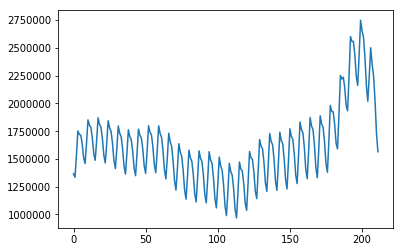

In [18]:
x.plot()

In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!

# Test Prophet - x vx. x_reg
# Test AMR NotPaid
# Test SoEu Paid
# Test ALL data upto 11/24/2018

# !!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!

In [147]:
import pandas as pd
#data = pd.read_csv('test_6m_nb.csv') # 6 months of AMR NotPaid
#data = pd.read_csv('test_All_nb.csv') # All of AMR NotPaid
#data = pd.read_csv('test_All_nb_2017-18.csv') # Excl. 2016 data AMR NotPaid
#data = pd.read_csv('test_All_SoEu_Paid.csv')
#data = pd.read_csv('test_All_AMR_Paid.csv')
#data = pd.read_csv('test_All_FR_Paid.csv')
#data = pd.read_csv('All_data_1124.csv')
#data = pd.read_csv('All_data_1124_2017-18.csv')
data = pd.read_csv('All_data_1124_2017-18-19.csv')

data.shape
data.head()

,ds,y
0,1/1/17,8705
1,1/2/17,12566
2,1/3/17,13101
3,1/4/17,15491
4,1/5/17,14138


In [102]:
def ProphetFxnNone(df, daysForecast):
    #m = Prophet(daily_seasonality = False, yearly_seasonality = True, weekly_seasonality = True,
    #               seasonality_mode='multiplicative')
    
    #m = Prophet(daily_seasonality = False, yearly_seasonality = 20, weekly_seasonality = True,
    #               seasonality_mode='multiplicative')

    #m = Prophet(daily_seasonality = False, yearly_seasonality = 20, weekly_seasonality = True,
    #               seasonality_mode='additive')

    #m = Prophet(daily_seasonality = False, yearly_seasonality = True, weekly_seasonality = False,
    #               seasonality_mode='multiplicative', changepoint_prior_scale = 0.5)
    
    #m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)
    #m.add_seasonality(name='weekly', period=7, fourier_order=10, prior_scale=2.0)
    #m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

    #m = Prophet(daily_seasonality = False, yearly_seasonality = True, weekly_seasonality = False,
    #               seasonality_mode='multiplicative', changepoint_prior_scale = 2.0)

# -------------------
    #x5 - best so far 
'''
    m = Prophet(daily_seasonality = False, yearly_seasonality = True, weekly_seasonality = False,
                   seasonality_mode='multiplicative')
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5, mode='multiplicative')
    m.add_seasonality(name='quarterly', period=91.25, fourier_order=8, mode='multiplicative')
'''
# -------------------
    m = Prophet(daily_seasonality = False, yearly_seasonality = True, weekly_seasonality = False,
                   seasonality_mode='multiplicative', growth='logistic')

    #m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1, mode='multiplicative')
    #m.add_seasonality(name='monthly', period=30.5, fourier_order=10)
    #m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5, mode='multiplicative')
    #m.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
    m.add_seasonality(name='quarterly', period=91.25, fourier_order=8, mode='multiplicative')

    m.fit(df)
    
    df['y'] = 40000 - df['y']
    df['cap'] = 40000
    df['floor'] = 15000
    future['cap'] = 40000
    future['floor'] = 15000
    #m = Prophet(growth='logistic')
    #m.fit(df)
    #fcst = m.predict(future)
    #fig = m.plot(fcst)
    
    future = m.make_future_dataframe(periods=daysForecast)
    forecast = m.predict(future)
    #forecast = Prophet(interval_width=0.95).fit(df).predict(future)
    #m = Prophet(mcmc_samples=300)
    #forecast = m.fit(df).predict(future)
    return forecast['yhat']

In [ ]:
#TO DO (AS OF 1/10/2019 5:05 PM)
#1. CHK OUT CAP, FLOOR
#2. ADD HOLIDAYS TO SEE IF THIS INCREASES 12% TO SOMETHING HIGHER
#3. ADD REGRESSORS (VISITS, LISTINGS) TO SEE IF INCREASES BEYOND 12%

# TO DO as of 1/11/2019 4:40 pm
#1. add change points in Feb, March, etc
#2. output latest results (chg4) and see the pct diff w/ Jan 2018
#3. simulate Jan 2019 or get actuals, and do the models again....you may get a high benchmark of 30k and forecasts
# may be reasonable that way (DONE - SEE BELOW - LOOKS LIKE BEST OPTION WILL BE TO TAKE JAN 2019 DATA TOO; 
# SEEMS LIKE JAN 2020 IS IN LINE WITH 35K BOOKINGS LIKE IT SHOULD BE)
#4. try cap/floor for Jan 2019

In [148]:
# Testing AMR_NotPaid_Prophet_Hols

def ProphetFxnNone(df, daysForecast):

    easter = pd.DataFrame({
        'holiday': 'easterSunday',
        'ds': pd.to_datetime(['2010-04-04','2011-04-24','2012-04-08','2013-03-31','2014-04-20',
                              '2015-04-05','2016-03-27','2017-04-16','2018-04-01','2019-04-21',
                            '2020-04-12','2021-04-04','2022-04-17','2023-04-09','2024-03-31']),
        'lower_window': -2,
        'upper_window': 0,
    })
    
    memorial = pd.DataFrame({
        'holiday': 'memorialMonday',
        'ds': pd.to_datetime(['2010-05-31','2011-05-30','2012-05-28','2013-05-27','2014-05-26',
                            '2015-05-25','2016-05-30','2017-05-29','2018-05-28','2019-05-27',
                            '2020-05-25','2021-05-31','2022-05-30','2023-05-29','2024-05-27']),
        'lower_window': -2,
        'upper_window': 0,
    })
    
    laborday = pd.DataFrame({
        'holiday': 'laborMonday',
        'ds': pd.to_datetime(['2010-09-6','2011-09-5','2012-09-3','2013-09-2','2014-09-1',
                            '2015-09-7','2016-09-5','2017-09-4','2018-09-3','2019-09-2',
                            '2020-09-7','2021-09-6','2022-09-5','2023-09-4','2024-09-2']),
        'lower_window': -2,
        'upper_window': 0,
    })
        
    thxgiving = pd.DataFrame({
        'holiday': 'thanksgiving',
        'ds': pd.to_datetime(['2010-11-25','2011-11-24','2012-11-22','2013-11-28','2014-11-27',
                            '2015-11-26','2016-11-24','2017-11-23','2018-11-22','2019-11-28',
                            '2020-11-26','2021-11-25','2022-11-24','2023-11-23','2024-11-28',]),
        'lower_window': 0,
        'upper_window': 1,
    })
    
    holidays = pd.concat((easter, memorial, laborday, thxgiving))
    
    # -------------------
    #x5 - best so far 
    
    changepoints=['2018-01-01','2018-01-04','2018-01-07','2018-01-09','2018-01-11',
                  '2018-01-13','2018-01-16','2018-01-20','2018-01-24','2018-01-31',
                  '2018-03-13','2018-03-16','2018-03-20','2018-03-24','2018-03-31']

    m = Prophet(#changepoints = changepoints,
                #n_changepoints=30,
                changepoint_prior_scale=0.001,
                #changepoint_range=0.9,
                holidays = holidays,
                daily_seasonality = False,
                yearly_seasonality = True,
                weekly_seasonality = False,
                seasonality_mode='multiplicative')
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5, mode='multiplicative') # 12 equal parts
    m.add_seasonality(name='quarterly', period=91.25, fourier_order=9, mode='multiplicative') # 4 equal parts

# -------------------

    m.fit(df)
       
    future = m.make_future_dataframe(periods=daysForecast)
    forecast = m.predict(future)
    return forecast['yhat']

In [ ]:
'''    
    # Python
    from fbprophet.plot import add_changepoints_to_plot
    fig = m.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), m, forecast)
    
    m = Prophet(changepoints=['2014-01-01'])
    forecast = m.fit(df).predict(future)
    fig = m.plot(forecast)
'''      


/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


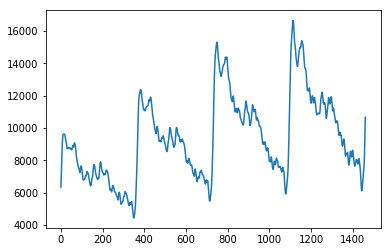

In [9]:
x = ProphetFxnNone(data, 442)  # use 402 for 11/24 data
x.plot()

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


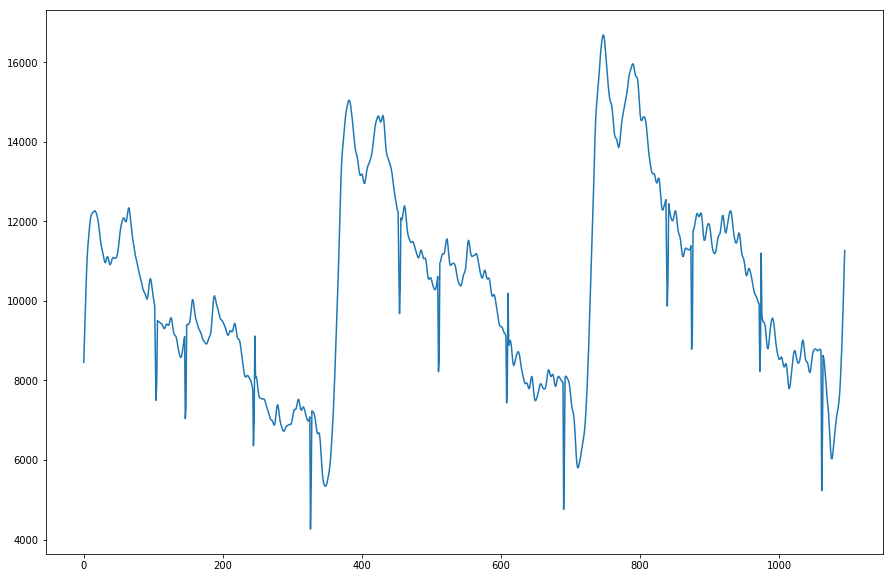

In [17]:
x2017_18 = ProphetFxnNone(data, 442)  # use 402 for 11/24 data
x2017_18.plot()

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


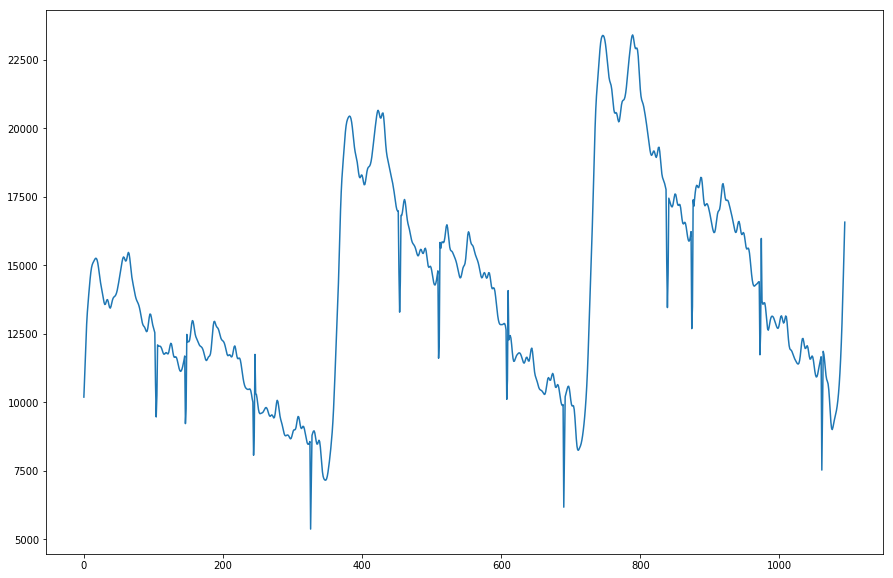

In [23]:
x_All_2017_18 = ProphetFxnNone(data, 402)  # use 402 for 11/24 data
x_All_2017_18.plot()

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


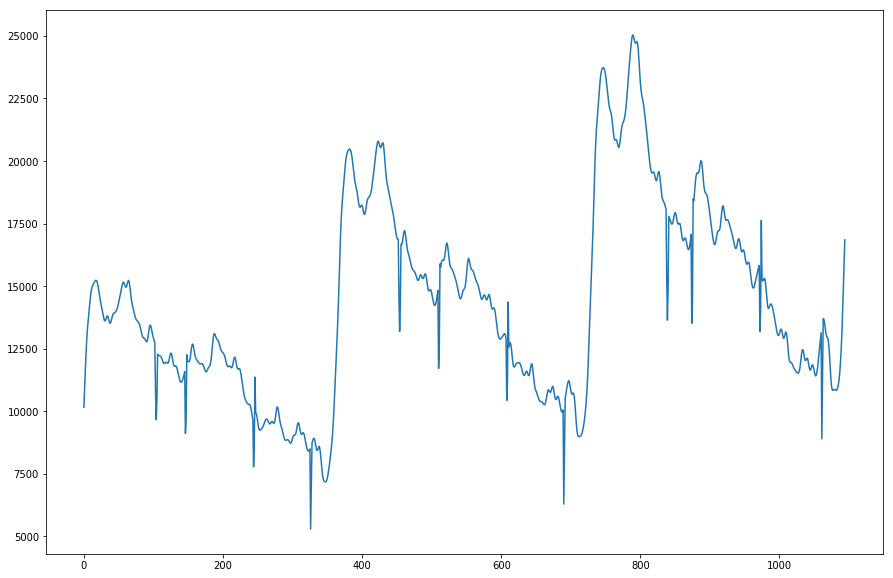

In [32]:
# 5 dates in Jan 2018
x_All_2017_18_chg = ProphetFxnNone(data, 402)  # use 402 for 11/24 data
x_All_2017_18_chg.plot()

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


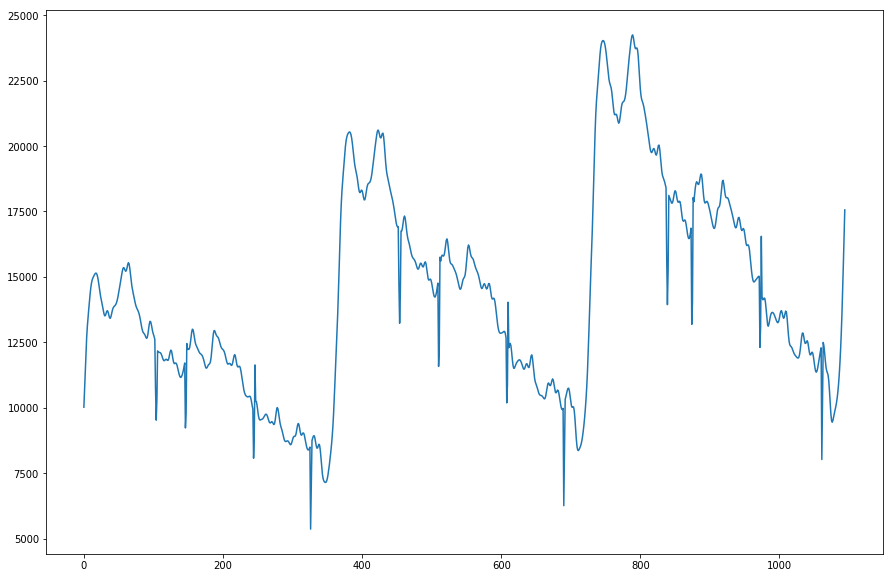

In [35]:
# 5 dates in Jan 2017
x_All_2017_18_chg2 = ProphetFxnNone(data, 402)  # use 402 for 11/24 data
x_All_2017_18_chg2.plot()

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


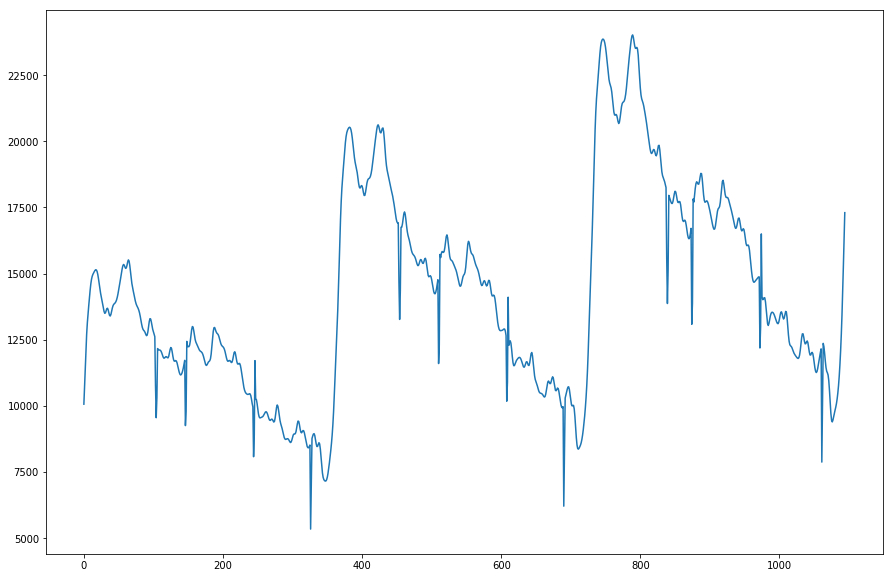

In [41]:
# 5 dates in Jan 2017
# 10 dates in Jan 2018
x_All_2017_18_chg3 = ProphetFxnNone(data, 402)  # use 402 for 11/24 data
x_All_2017_18_chg3.plot()

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


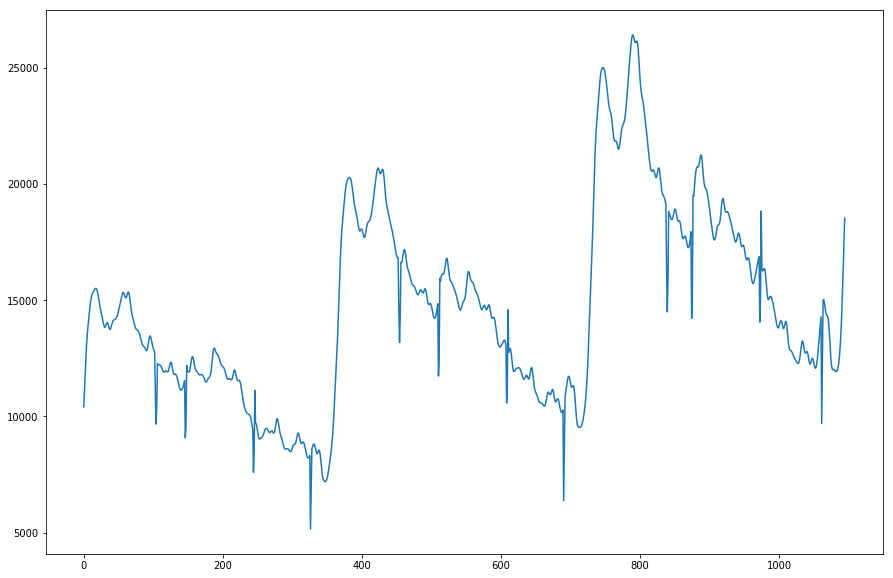

In [63]:
# changepoint range
# changepoint prior scale (0.001) (0.0001 did not make much of a diff.)

x_All_2017_18_chg4 = ProphetFxnNone(data, 402)  # use 402 for 11/24 data
x_All_2017_18_chg4.plot()

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


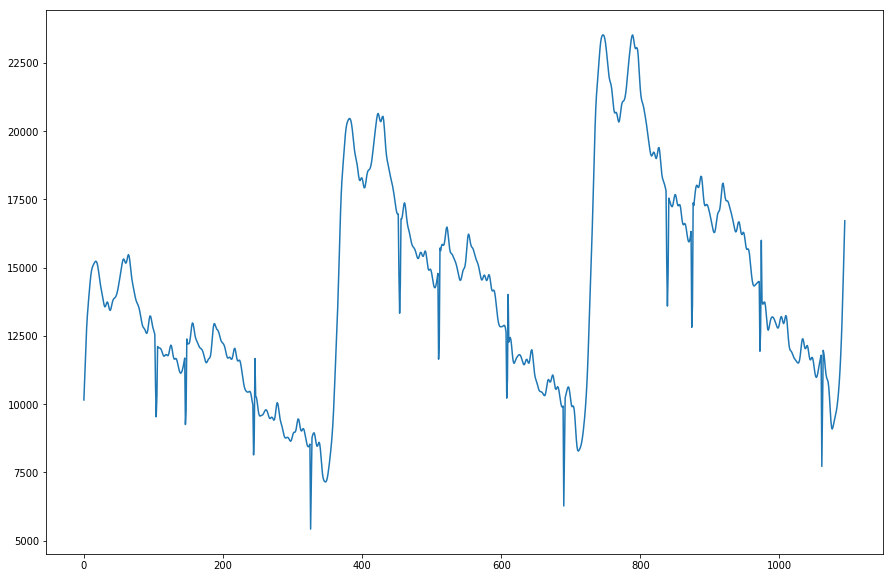

In [56]:
# changepoint range
# changepoint prior scale (0.05)

x_All_2017_18_chg5 = ProphetFxnNone(data, 402)  # use 402 for 11/24 data
x_All_2017_18_chg5.plot()

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


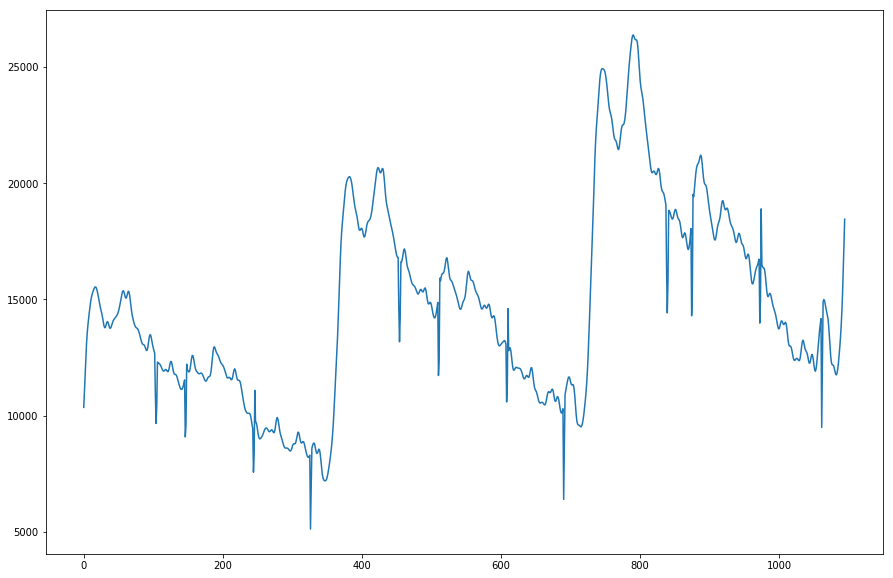

In [131]:
# changepoint range (0.9)
# changepoint prior scale (0.005)
# changepoints (Jan, Mar)

x_All_2017_18_chg6 = ProphetFxnNone(data, 402)  # use 402 for 11/24 data
x_All_2017_18_chg6.plot()

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


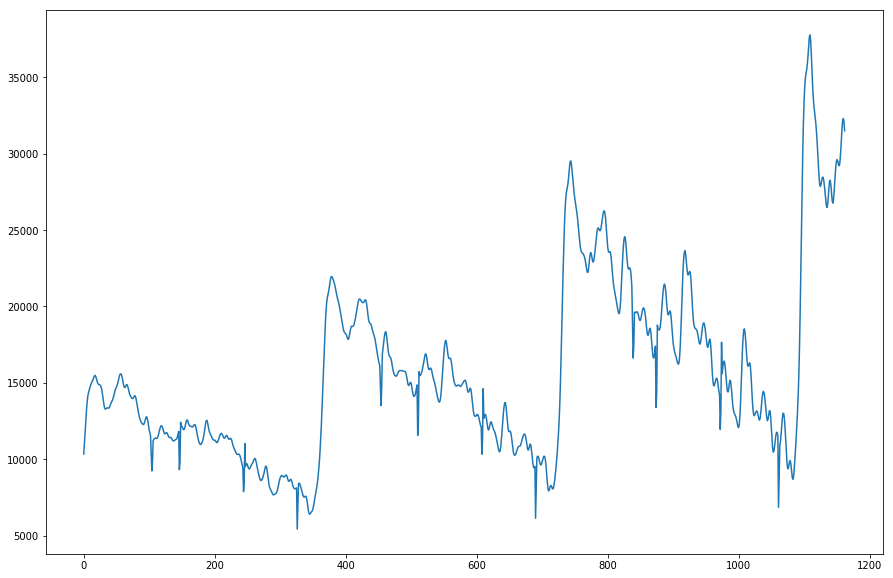

In [135]:
# changepoint prior scale (0.0001)
# use Jan 2019 data

x_All_2017_18_chg7 = ProphetFxnNone(data, 402)  # use 402 for 11/24 data
x_All_2017_18_chg7.plot()

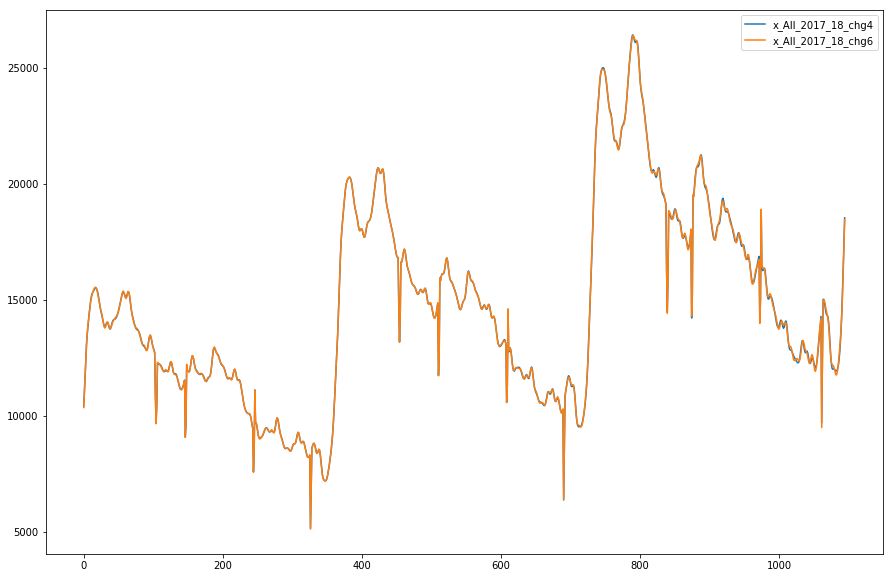

In [137]:
prophet_fcst = pd.concat([x_All_2017_18_chg4, x_All_2017_18_chg6], axis=1)
prophet_fcst.columns = ['x_All_2017_18_chg4', 'x_All_2017_18_chg6']

from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

prophet_fcst.plot()

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


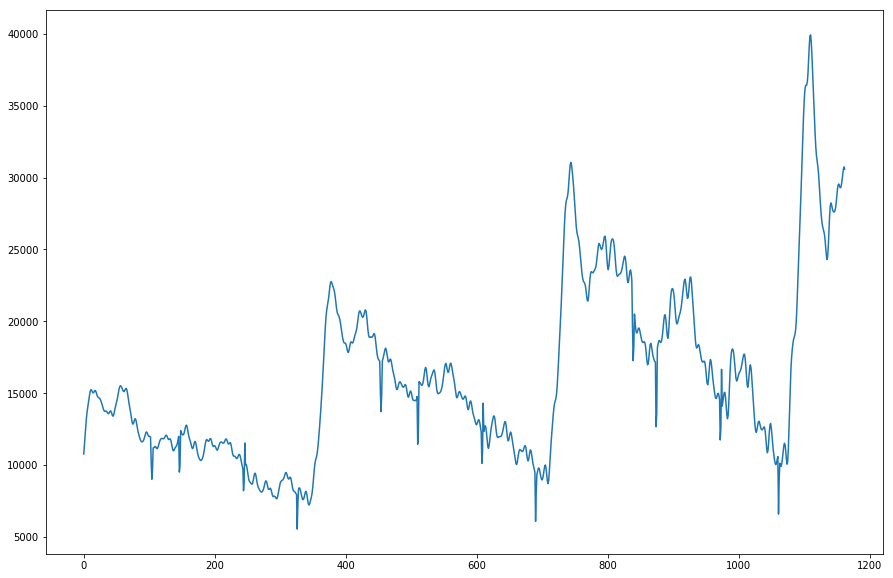

In [149]:
# changepoint prior scale (0.0001)
# use Jan 2019 data

x_All_2017_18_19_chg8 = ProphetFxnNone(data, 402)  # use 402 for 11/24 data
x_All_2017_18_19_chg8.plot()

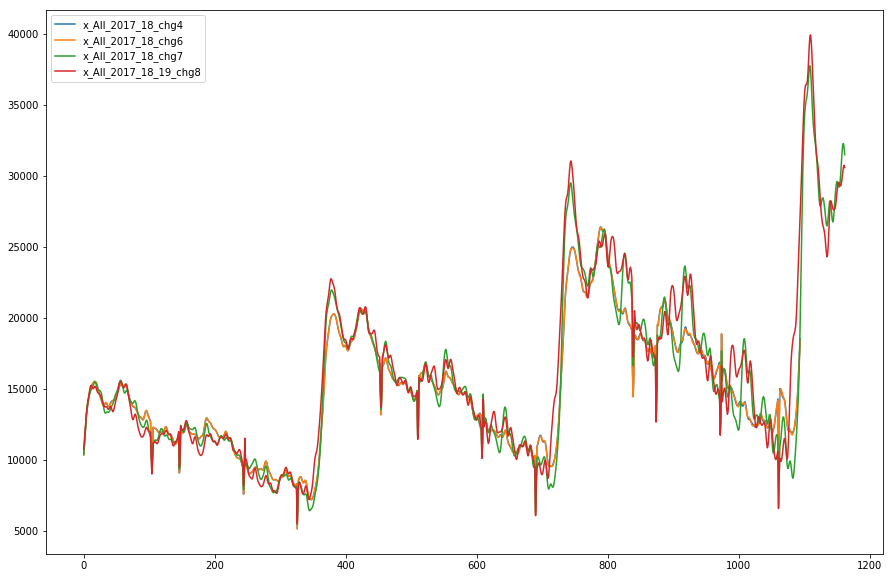

In [150]:
#prophet_fcst = pd.concat([x_All_2017_18, x_All_2017_18_chg, x_All_2017_18_chg2, x_All_2017_18_chg3, x_All_2017_18_chg4], axis=1)
#prophet_fcst.columns = ['x_All_2017_18', 'x_All_2017_18_chg', 'x_All_2017_18_chg2', 'x_All_2017_18_chg3', 'x_All_2017_18_chg4']

#prophet_fcst = pd.concat([x_All_2017_18, x_All_2017_18_chg, x_All_2017_18_chg4, x_All_2017_18_chg5, x_All_2017_18_chg6], axis=1)
#prophet_fcst.columns = ['x_All_2017_18', 'x_All_2017_18_chg', 'x_All_2017_18_chg4', 'x_All_2017_18_chg5', 'x_All_2017_18_chg6']

prophet_fcst = pd.concat([x_All_2017_18_chg4, x_All_2017_18_chg6, x_All_2017_18_chg7, x_All_2017_18_19_chg8], axis=1)
prophet_fcst.columns = ['x_All_2017_18_chg4', 'x_All_2017_18_chg6', 'x_All_2017_18_chg7', 'x_All_2017_18_19_chg8']

from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

prophet_fcst.plot()

In [151]:
x_All_2017_18_19_chg8 = pd.DataFrame(x_All_2017_18_19_chg8)
x_All_2017_18_19_chg8.to_csv("x_All_2017_18_19_chg8.csv")

In [24]:
xAllHols_2017_18 = pd.DataFrame(x_All_2017_18)
xAllHols_2017_18.to_csv("xAllHols_2017_18.csv")

In [18]:
xamrNPHols_2017_18 = pd.DataFrame(x2017_18)
xamrNPHols_2017_18.to_csv("xamrNPHols_2017_18.csv")

In [109]:
xDFamrNP = pd.DataFrame(x)
xDFamrNP.to_csv("xDFamrNP.csv")

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


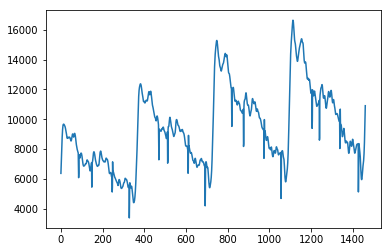

In [11]:
xHols = ProphetFxnNone(data, 442)  # use 402 for 11/24 data
xHols.plot()

In [13]:
xDFamrNPHols = pd.DataFrame(xHols)
xDFamrNPHols.to_csv("xDFamrNPHols.csv")

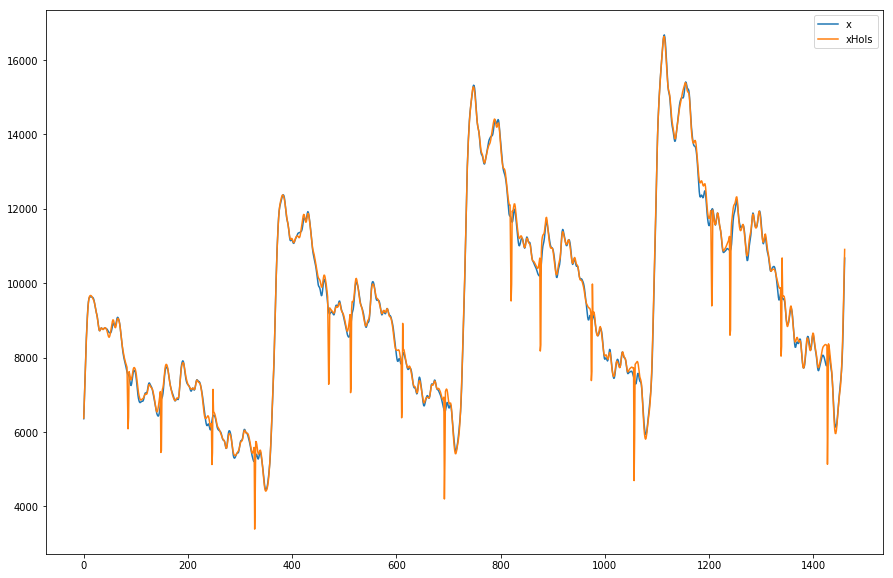

In [20]:
prophet_fcst = pd.concat([x, xHols], axis=1)
prophet_fcst.columns = ['x', 'xHols']

from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

prophet_fcst.plot()

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


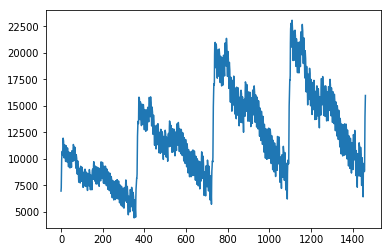

In [23]:
x1 = ProphetFxnNone(data, 403)
x1.plot()

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


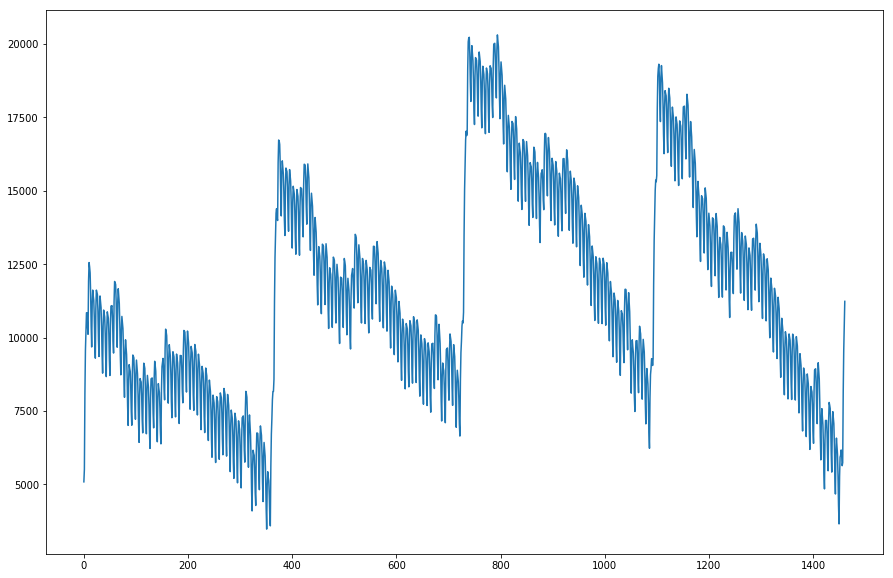

In [26]:
x2 = ProphetFxnNone(data, 403)
x2.plot()

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


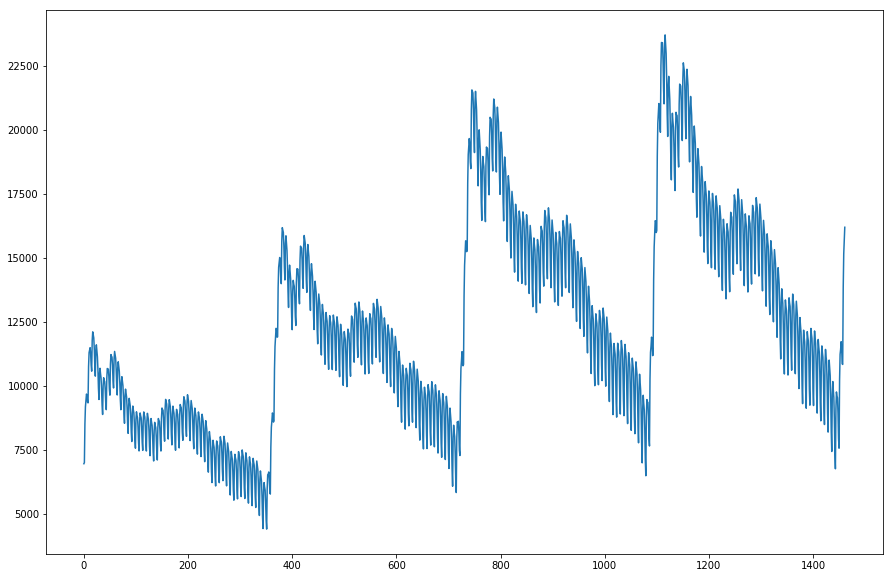

In [29]:
x3 = ProphetFxnNone(data, 403)
x3.plot()

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


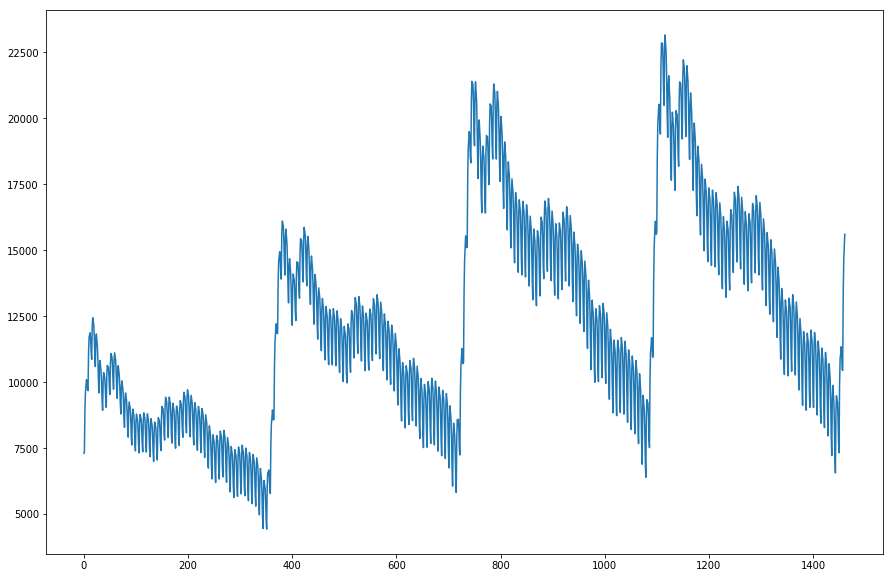

In [35]:
x4 = ProphetFxnNone(data, 403)
x4.plot()

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


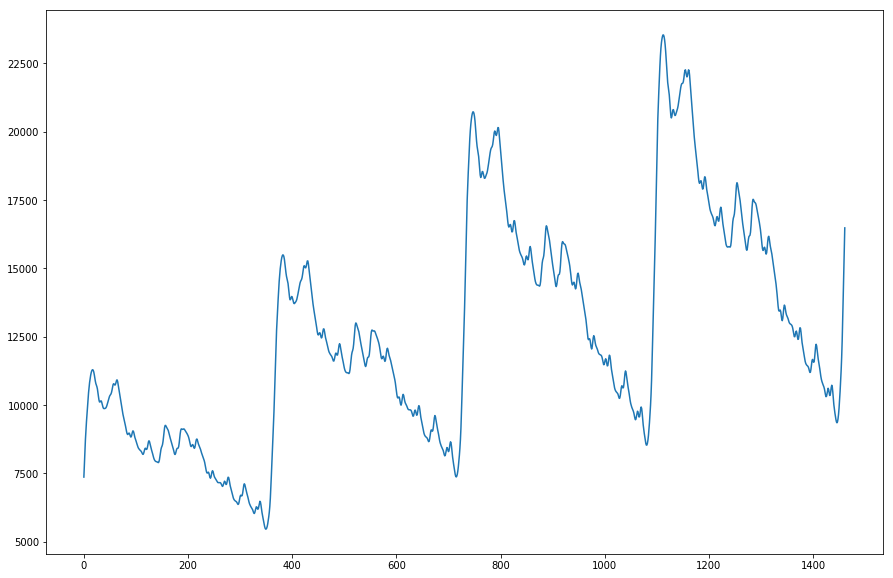

In [38]:
x5 = ProphetFxnNone(data, 403)
x5.plot()

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


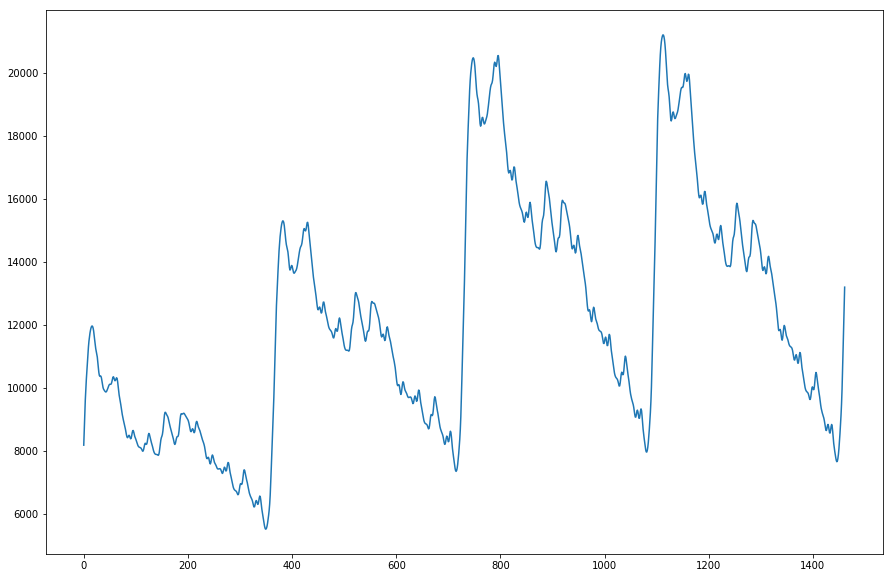

In [41]:
x6 = ProphetFxnNone(data, 403)
x6.plot()

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


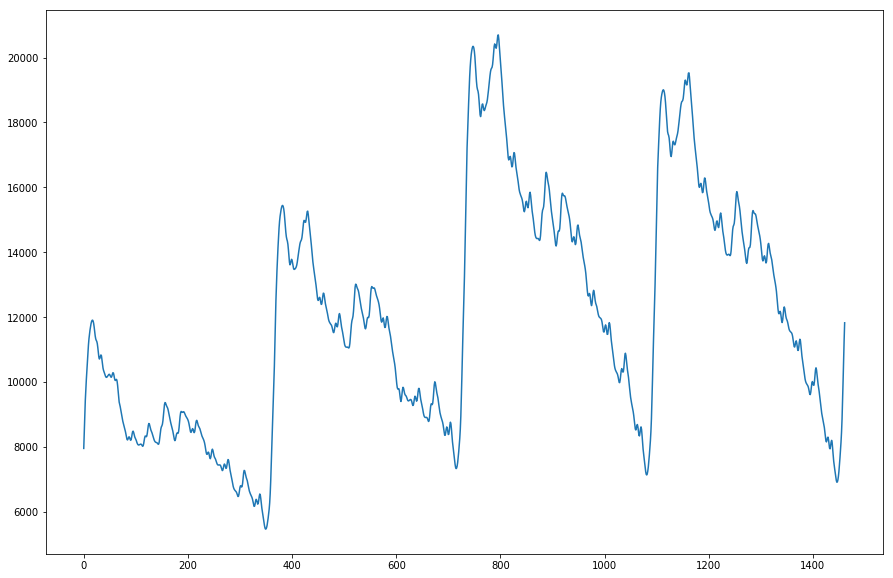

In [45]:
x7 = ProphetFxnNone(data, 403)
x7.plot()

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


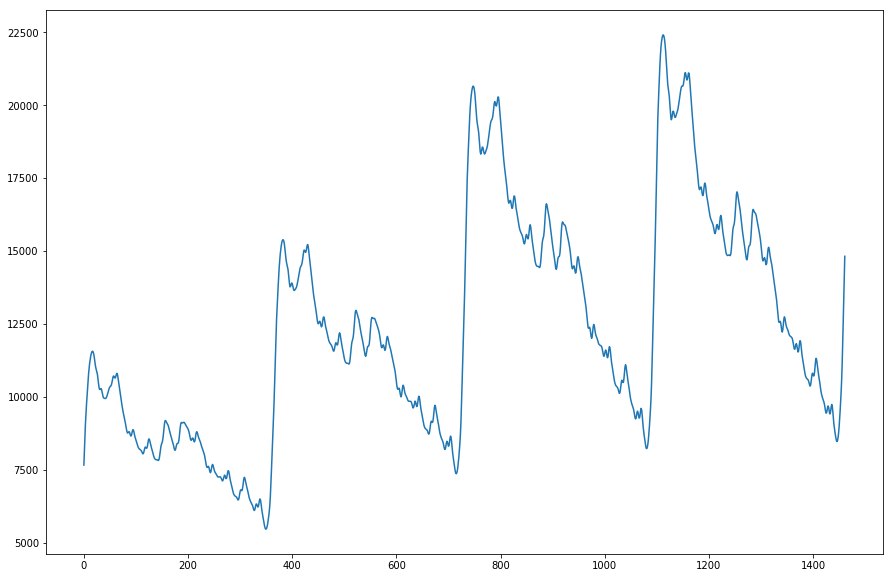

In [49]:
x8 = ProphetFxnNone(data, 403)
x8.plot()

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


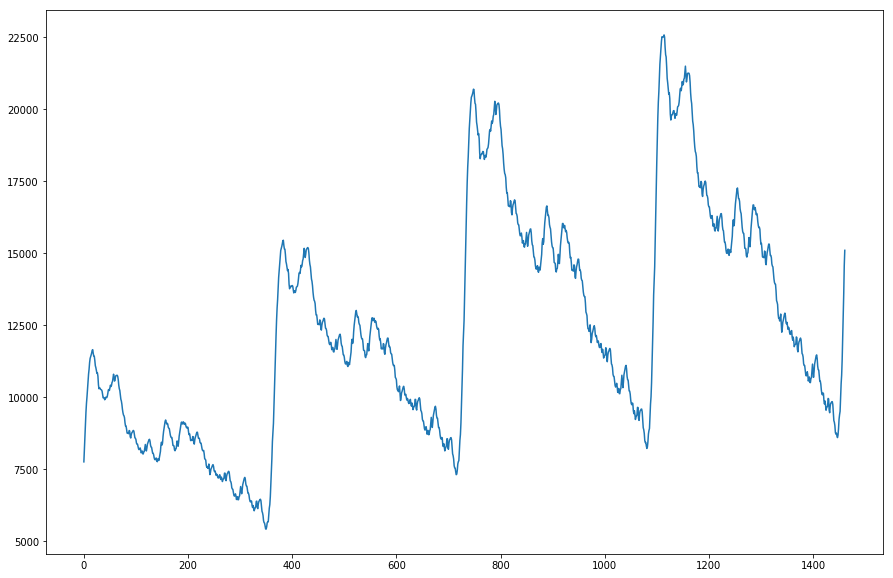

In [52]:
x9 = ProphetFxnNone(data, 403)
x9.plot()

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


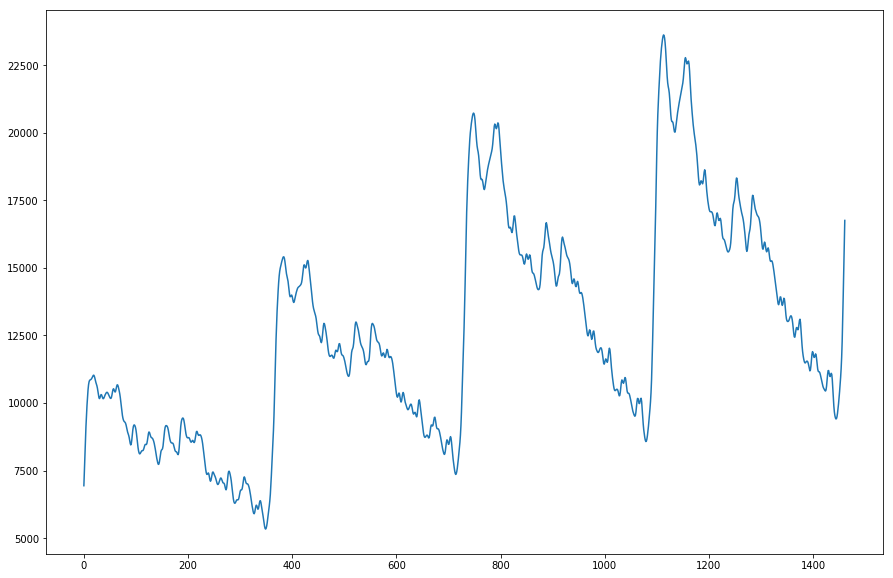

In [76]:
x10 = ProphetFxnNone(data, 403)
x10.plot()

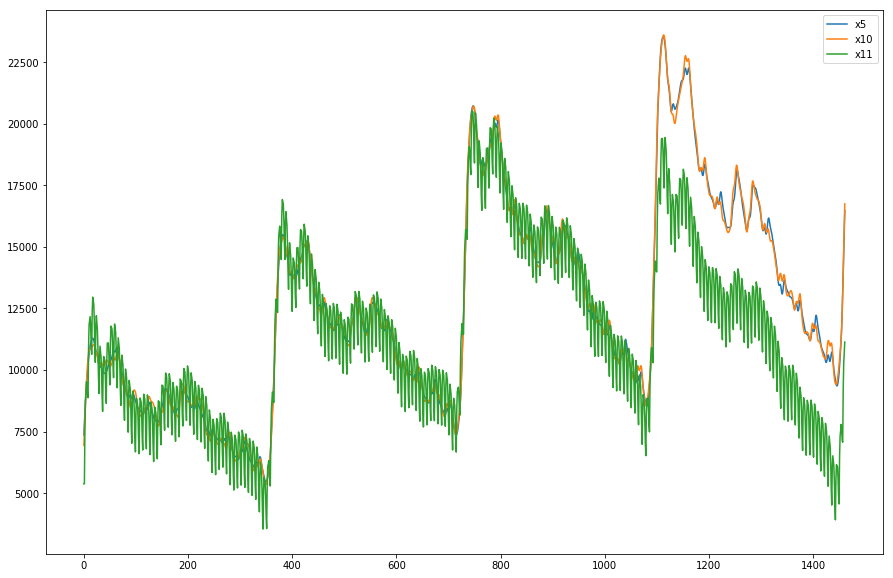

In [97]:
#prophet_fcst = pd.concat([x, x1, x2, x3, x4, x5, x6], axis=1)
#prophet_fcst.columns = ['x', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']

prophet_fcst = pd.concat([x5, x10, x11], axis=1)
prophet_fcst.columns = ['x5', 'x10', 'x11']

from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

prophet_fcst.plot()

In [54]:
x5DF = pd.DataFrame(x5)
x5DF.to_csv("x5_All_1124_Fcst.csv")

In [19]:
xDF = pd.DataFrame(x1)
xDF.to_csv("x1_All_1124_Fcst.csv")

In [14]:
with open('xdf.csv', 'w') as f:
    print(xdf, file=f)

In [10]:
with open('x_Alldata_1124.csv', 'w') as f:
    print(x, file=f)

In [131]:
"""
add regressors to Prophet
"""
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import logging
import warnings
import pyper as pr

def ProphetFxnNone(df, daysForecast):
    print(df)
    m = Prophet(daily_seasonality = False, 
                yearly_seasonality = True, 
                weekly_seasonality = True,
                seasonality_mode='multiplicative')
    m.add_regressor('visits')
    #m.add_regressor('visits')
    m.fit(df)
        
    vis = ProphetVisitsNone(df, daysForecast)
    vis = pd.DataFrame(vis)
    vis.columns = ['visits']
    print(vis)
    #df['visits'] = df['ds'].apply(vis)

    future_ds = m.make_future_dataframe(periods=daysForecast)
    future = pd.concat([future_ds,vis],axis=1)
    future.columns = ['ds', 'visits']
    
    print(future)
    forecast = m.predict(future)
    return forecast['yhat']

def ProphetVisitsNone(df, daysForecast):
    # predict visits
    df = df[['ds', 'visits']]
    df.columns = ['ds', 'y']
    print(df)
    v = Prophet(daily_seasonality = False, 
                yearly_seasonality = True, 
                weekly_seasonality = True,
                seasonality_mode='multiplicative')
    v.fit(df)
    
    future = v.make_future_dataframe(periods=daysForecast)
    print(future)
    forecast = v.predict(future)
    vis = forecast['yhat']
    vis.columns = ['visits_fcst']
    return vis

In [132]:
x_reg = ProphetFxnNone(data, 442)

            ds region marketing  visits    br   inq   gb  cb           ss  \
0       1/1/16     FR      Paid   46598   103  2706   69   4     0.000000   
1       1/2/16     FR      Paid   70908   121  4187   85   4     0.000000   
2       1/3/16     FR      Paid   97079   224  6373  160   4     0.000000   
3       1/4/16     FR      Paid   88109   181  5568  159  15     0.000000   
4       1/5/16     FR      Paid   89732   193  5679  158   9     0.000000   
5       1/6/16     FR      Paid   82155   180  5146  156  19     0.000000   
6       1/7/16     FR      Paid   78618   187  4817  158  10     0.000000   
7       1/8/16     FR      Paid   75440   171  4307  148   3     0.000000   
8       1/9/16     FR      Paid   83920   226  5079  168   4     0.000000   
9      1/10/16     FR      Paid  124998   361  7955  264  12     0.000000   
10     1/11/16     FR      Paid   97658   239  5828  217  16     0.000000   
11     1/12/16     FR      Paid   86314   213  5182  184  16     0.000000   

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


            ds       y
0       1/1/16   46598
1       1/2/16   70908
2       1/3/16   97079
3       1/4/16   88109
4       1/5/16   89732
5       1/6/16   82155
6       1/7/16   78618
7       1/8/16   75440
8       1/9/16   83920
9      1/10/16  124998
10     1/11/16   97658
11     1/12/16   86314
12     1/13/16   83756
13     1/14/16   78047
14     1/15/16   69200
15     1/16/16   79469
16     1/17/16  114454
17     1/18/16   99481
18     1/19/16   88710
19     1/20/16   89816
20     1/21/16   75872
21     1/22/16   66875
22     1/23/16   76154
23     1/24/16  109149
24     1/25/16   91765
25     1/26/16   39416
26     1/27/16   78322
27     1/28/16   70952
28     1/29/16   68719
29     1/30/16   84897
...        ...     ...
989    9/16/18   76440
990    9/17/18   70178
991    9/18/18   67224
992    9/19/18   65746
993    9/20/18   59183
994    9/21/18   55997
995    9/22/18   59358
996    9/23/18   87919
997    9/24/18   71790
998    9/25/18   99007
999    9/26/18   97892
1000   9/27

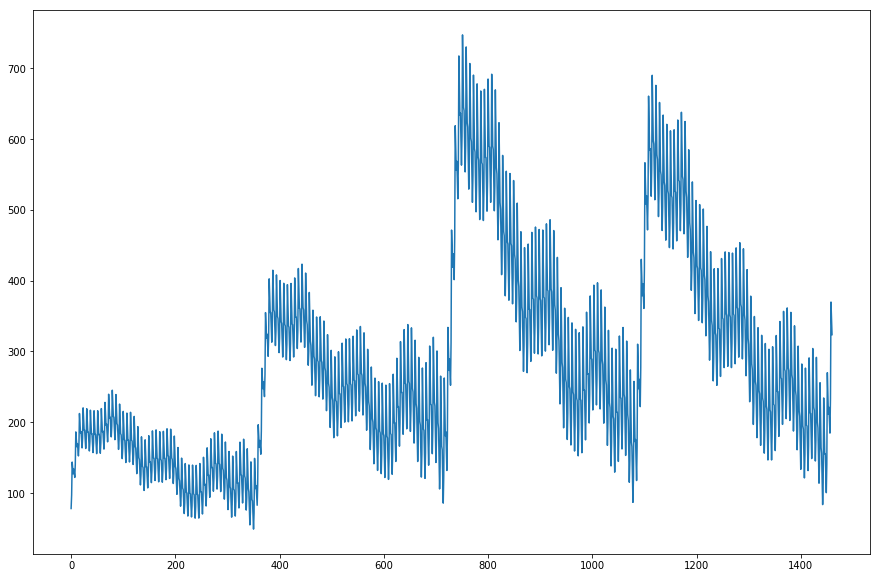

In [133]:
x_reg.plot()

In [134]:
x.head()

0     82.072452
1     96.918011
2    135.893386
3    128.853476
4    124.482626
Name: yhat, dtype: float64

In [135]:
x_reg.head()

0     78.078831
1     97.271515
2    143.698077
3    134.750899
4    127.057188
Name: yhat, dtype: float64

In [136]:
x.tail()

1456    376.659798
1457    465.739193
1458    712.071538
1459    660.257180
1460    627.655196
Name: yhat, dtype: float64

In [137]:
x_reg.tail()

1456    184.685611
1457    233.209809
1458    369.903344
1459    346.684448
1460    323.782414
Name: yhat, dtype: float64

In [138]:
prophet_fcst = pd.concat([x, x_reg], axis=1)
prophet_fcst.columns = ['x', 'x_reg']

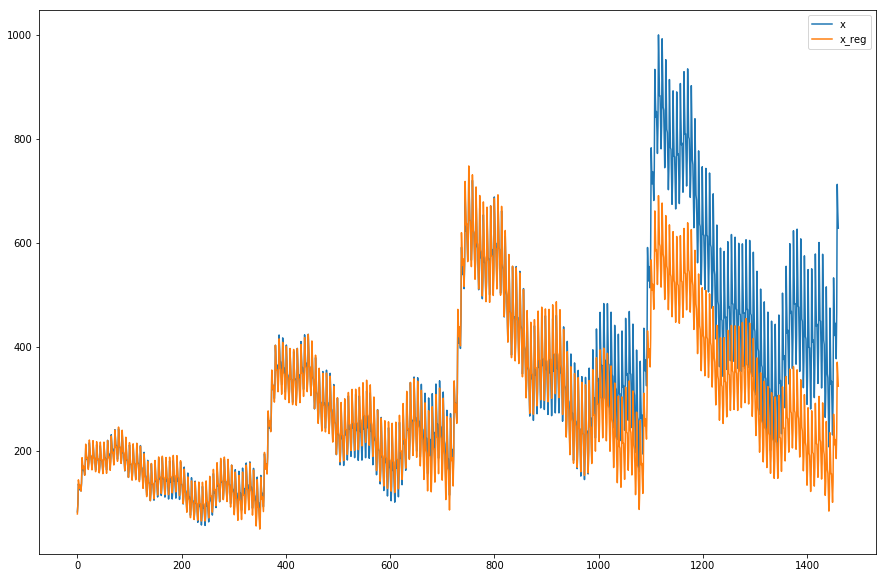

In [139]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

prophet_fcst.plot()